# 목차
 
* 데이터 불러오기
* 데이터 전처리
* 시계열의 안정성 체크하기
* 학습, 테스트 데이터셋 생성
* 적정 ARIMA 모수 찾기
* ARIMA 모델 훈련과 테스트
* 다른 주식 종목에 대해 반복하기
* Reference
* 회고
------------------------
## 루브릭 평가기준

1. 시계열의 안정성이 충분히 확인되었는가?

  플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며, 이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어있음

2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?

  p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨

3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?

  3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams



# 데이터 불러오기

In [18]:
dataset_filepath = '/content/drive/MyDrive/아이펠 데이터/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [19]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284
...,...,...,...,...,...,...
2021-05-12,80800.0,81200.0,79800.0,80000.0,80000.000000,35812268
2021-05-13,78900.0,79600.0,78400.0,78500.0,78500.000000,31490096
2021-05-14,79000.0,80300.0,78900.0,80100.0,80100.000000,16450920


# 데이터 전처리

In [20]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [21]:
# 로그 변환

ts[ts==0]

Series([], Name: Close, dtype: float64)

In [22]:
# 0 인 값 없으므로 그냥 로그 씌워도 무방

ts_log = np.log(ts)

# 시계열의 안정성 체크하기

In [23]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [24]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

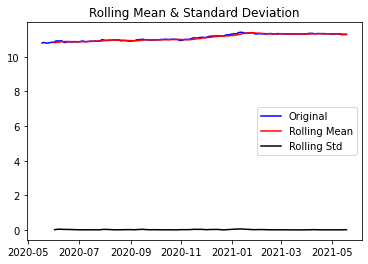

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


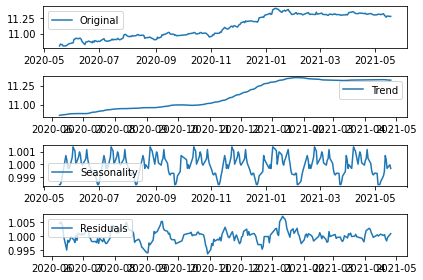

In [25]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [26]:
# residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


p-value가 0에 가까운 값이 나왔기 때문에 '시계열이 안정적이지 않다'라는 귀무가설을 기각하고 대립가설을 채택하여 '시계열이 안정적이다'라는 결론이 도출된다.

또한 Residual에서는 어떠한 패턴이나 특성이 나타나서는 안 되는데 위에서 그린 그래프에서 패턴이 나타나지 않으므로 모델에 잘 적용되었음을 의미한다.

# 학습, 테스트 데이터셋 생성

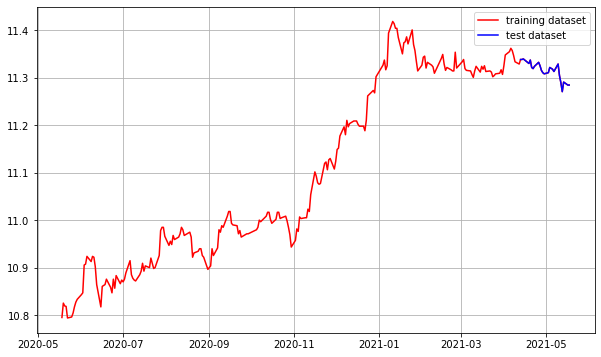

In [27]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 시계열 데이터에선 테스트 데이터셋을 맨 끝에서 가져오는 것이 좋다.

# 적정 ARIMA 모수 찾기

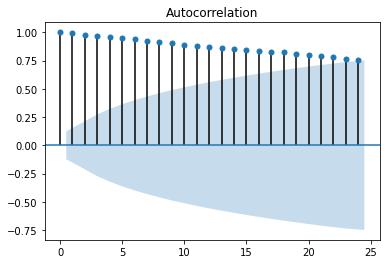

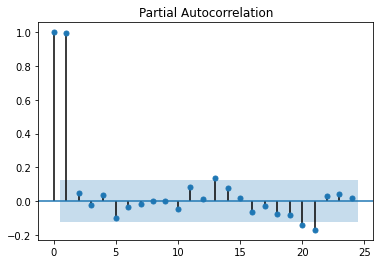

In [28]:
# ACF, PACF 그려보고 p,q 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


시계열데이터는 AR과 MA 둘 중 하나인 경우가 대부분이다. AR은 자기회귀모델로 일정한 균형 수준을 유지하는 경우이며 ARIMA 모수로 p를 갖는다. 반대로 MA는 이동평균 모델로 시계열 데이터가 최근의 증감 패턴을 지속하는 경우이며 이 때는 ARIMA모수로 q를 갖는다.

그리고 I, 차분누적 모델도 존재한다. 간단히 말해 Seasonality를 고려한다는 뜻이다.

ARIMA 모델은 위 3가지 경우를 전부 고려하여 적정한 수준을 찾는다.

시각화를 했을 때 ACF,PACF 그래프에서 AR 모델은 시차 p이후에 PACF가 0에 수렴하고, MA 모델은 시차 q 이후에 ACF가 0에 수렴하는 모습을 보인다.

위 경우에는 p>=2 인 구간에서 PACF가 0에 수렴하므로 AR 모델일 것으로 볼 수 있으며 ACF는 점차 감소하고 있는 형태이므로 q는 고려할 필요가 없어서 0으로 두면 된다. p는 

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


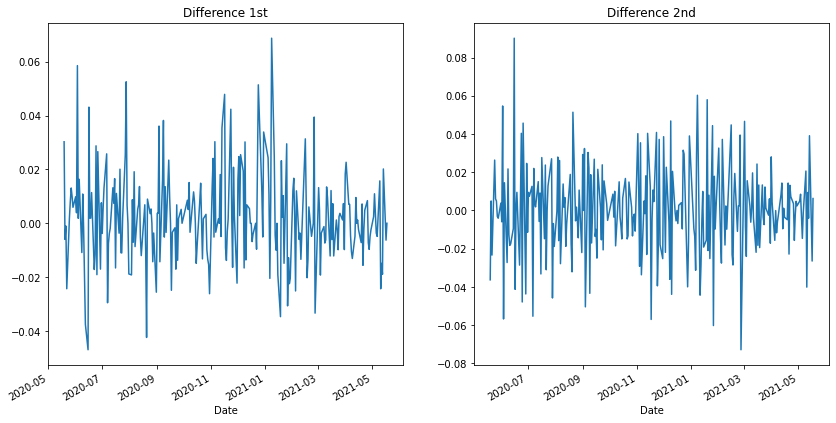

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


In [36]:
# 차분 안정성 확인 후 d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]


augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]


fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(1,2,1)
diff_1.plot(title='Difference 1st')

ax2 = fig.add_subplot(1,2,2)
diff_2.plot(title='Difference 2nd')

plt.show()



augmented_dickey_fuller_test(diff_2)

1,2차분 안정성을 확인해본 결과 둘 다 아주 작은 범위 내에서 움직이는 모습을 보이므로 안정적이다. 따라서 d는 0부터 시작하는 것이 좋아보인다.

# ARIMA 모델 훈련과 테스트

In [30]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  # p,d,q 모수
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Fri, 30 Sep 2022   AIC                          -1156.722
Time:                        11:14:27   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


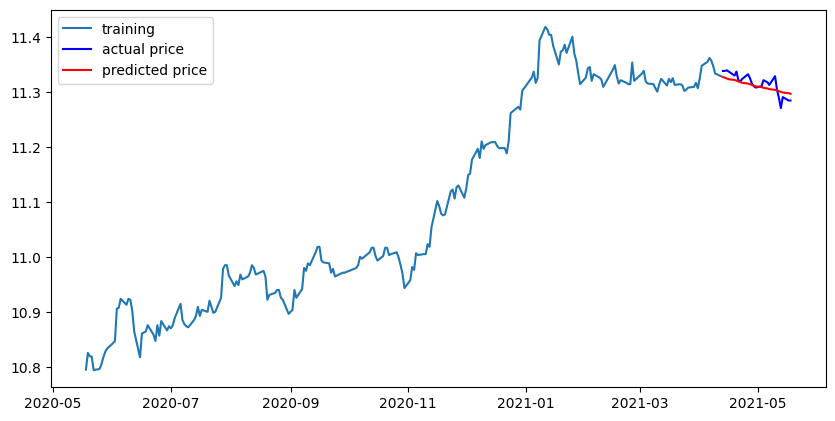

In [31]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [32]:
# 오차 함수

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014240584
MAE:  843.7579531509296
RMSE:  1024.194122920093
MAPE: 1.03%


결과적으로 MAPE 값이 1.03% 로 매우 낮으며 이 모델이 예측을 잘 해내고 있음을 확인했다.

# 다른 주식 종목에 대해 위 과정 반복하기

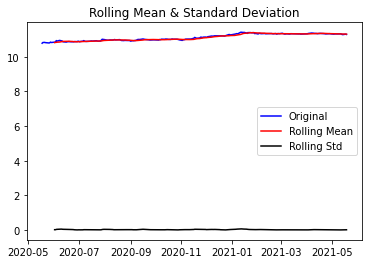

Results of Dickey-Fuller Test:
Test Statistic                  -1.496329
p-value                          0.535327
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


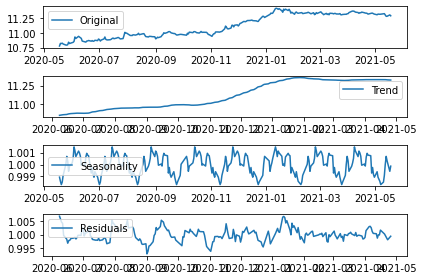

In [37]:
ts = df['Open']
# 결측치 처리
ts = ts.interpolate(method='time')
# 로그 변환
ts_log = np.log(ts)
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [38]:
# residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.055312e+00
p-value                        1.249248e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


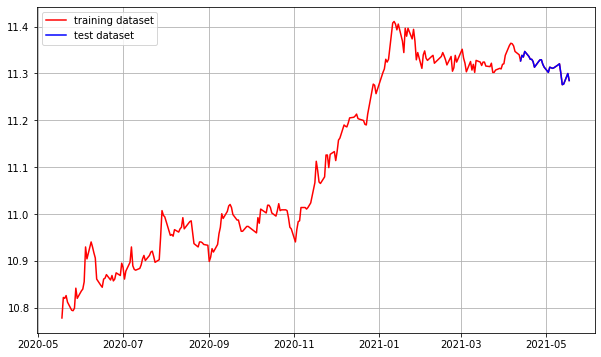

In [39]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 시계열 데이터에선 테스트 데이터셋을 맨 끝에서 가져오는 것이 좋다.

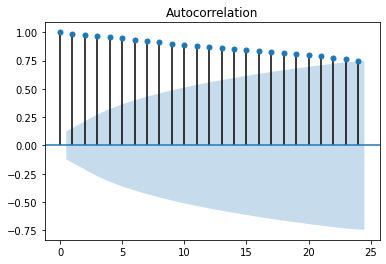

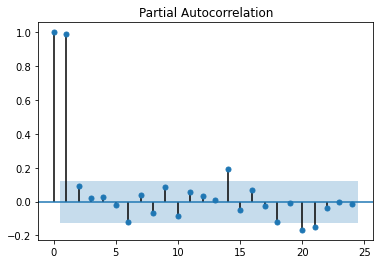

In [40]:
# ACF, PACF 그려보고 p,q 구하기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.672693e+01
p-value                        1.393437e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


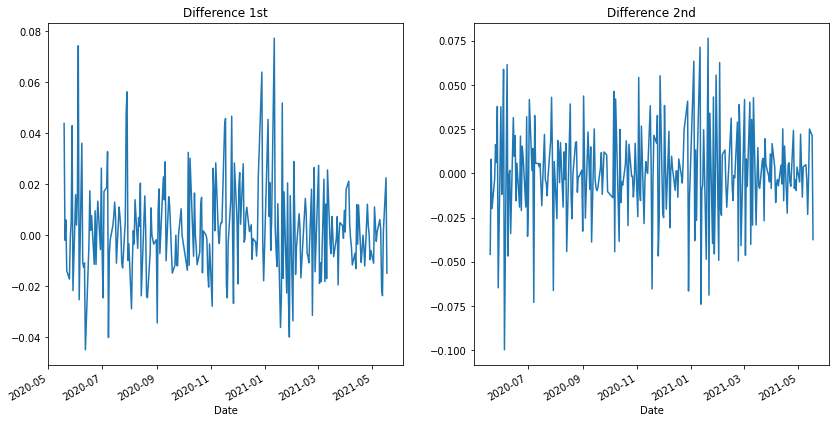

In [41]:
# 차분 안정성 확인 후 d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]


augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]


fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(1,2,1)
diff_1.plot(title='Difference 1st')

ax2 = fig.add_subplot(1,2,2)
diff_2.plot(title='Difference 2nd')

plt.show()

In [42]:
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  # p,d,q 모수
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 560.987
Date:                Fri, 30 Sep 2022   AIC                          -1111.974
Time:                        12:25:17   BIC                          -1094.894
Sample:                             0   HQIC                         -1105.081
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.136     81.693      0.000      10.824      11.356
ar.L1          0.7872      1.615      0.488      0.626      -2.377       3.952
ar.L2          0.2059      1.606      0.128      0.8

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


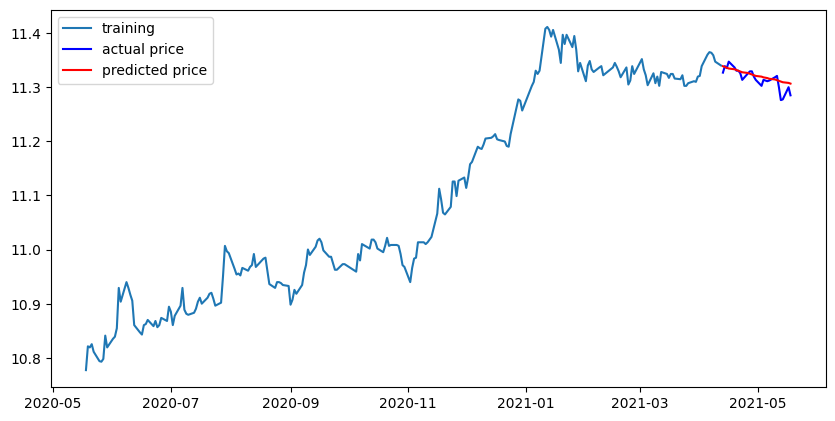

In [43]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [44]:
# 오차함수

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1027163.7188587174
MAE:  715.4566262268216
RMSE:  1013.490857807172
MAPE: 0.88%


Open 항목에서 MAPE 0.88%

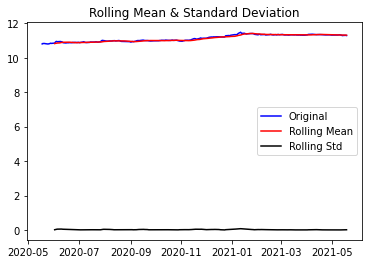

Results of Dickey-Fuller Test:
Test Statistic                  -1.431495
p-value                          0.567087
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


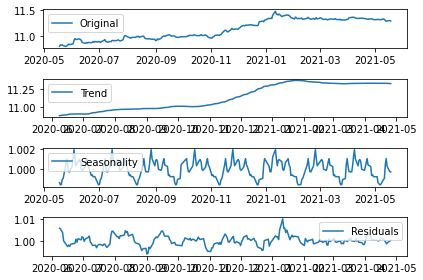

In [45]:
ts = df['High']
# 결측치 처리
ts = ts.interpolate(method='time')
# 로그 변환
ts_log = np.log(ts)
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [46]:
# residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.997780e+00
p-value                        1.685430e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


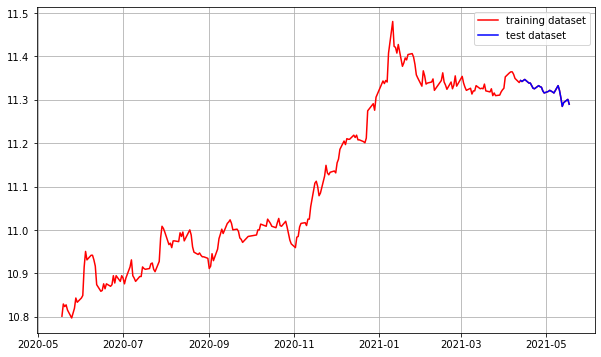

In [47]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 시계열 데이터에선 테스트 데이터셋을 맨 끝에서 가져오는 것이 좋다.

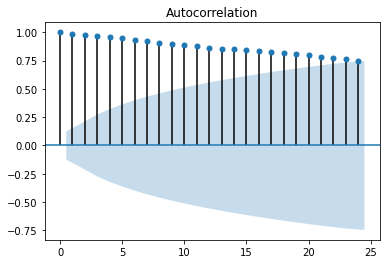

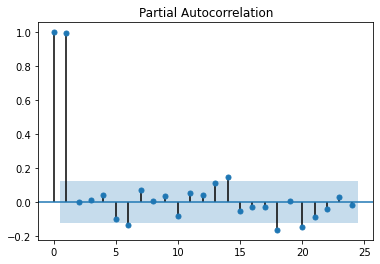

In [48]:
# ACF, PACF 그려보고 p,q 구하기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.475670e+01
p-value                        2.437648e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


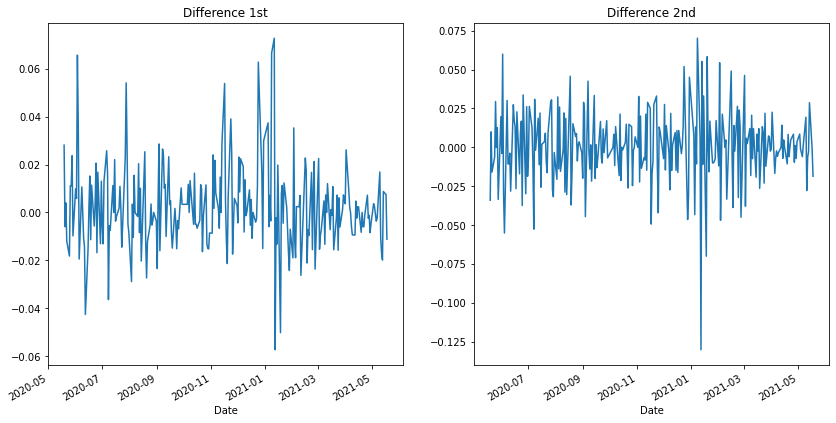

In [49]:
# 차분 안정성 확인 후 d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]


augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]


fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(1,2,1)
diff_1.plot(title='Difference 1st')

ax2 = fig.add_subplot(1,2,2)
diff_2.plot(title='Difference 2nd')

plt.show()

In [50]:
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  # p,d,q 모수
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 580.292
Date:                Fri, 30 Sep 2022   AIC                          -1150.583
Time:                        12:37:08   BIC                          -1133.503
Sample:                             0   HQIC                         -1143.689
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0732      2.240      4.943      0.000       6.683      15.464
ar.L1          0.0925      0.051      1.800      0.072      -0.008       0.193
ar.L2          0.9063      0.052     17.466      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


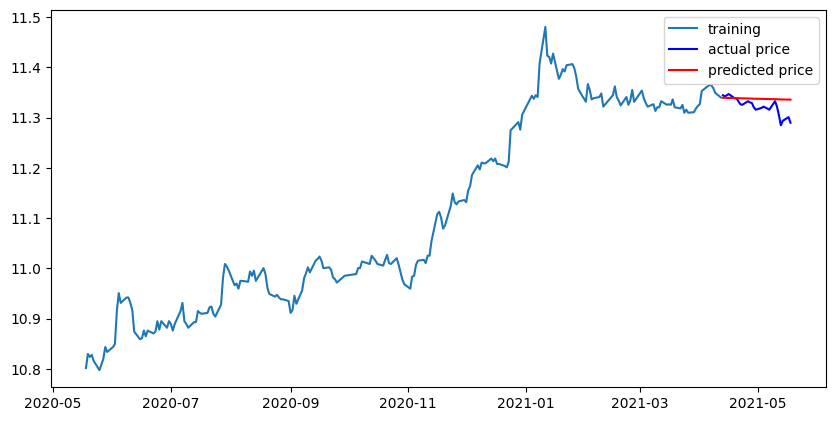

In [51]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [52]:
# 오차함수

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3189912.32341883
MAE:  1361.1233950271667
RMSE:  1786.0325650499294
MAPE: 1.67%


High에서 MAPE : 1.67%

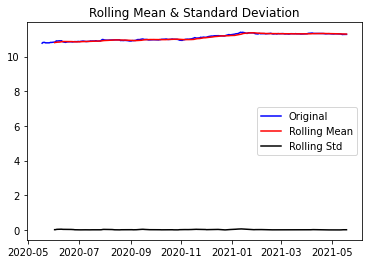

Results of Dickey-Fuller Test:
Test Statistic                  -1.190614
p-value                          0.677620
#Lags Used                       1.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


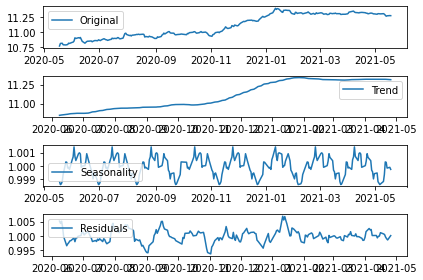

In [53]:
ts = df['Low']
# 결측치 처리
ts = ts.interpolate(method='time')
# 로그 변환
ts_log = np.log(ts)
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [54]:
# residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.225280e+00
p-value                        5.106511e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


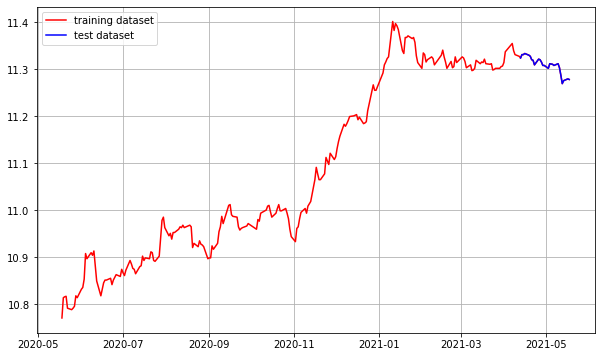

In [55]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 시계열 데이터에선 테스트 데이터셋을 맨 끝에서 가져오는 것이 좋다.

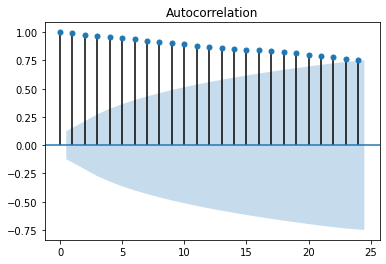

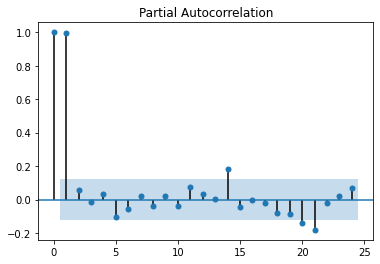

In [56]:
# ACF, PACF 그려보고 p,q 구하기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.457943e+01
p-value                        4.493484e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


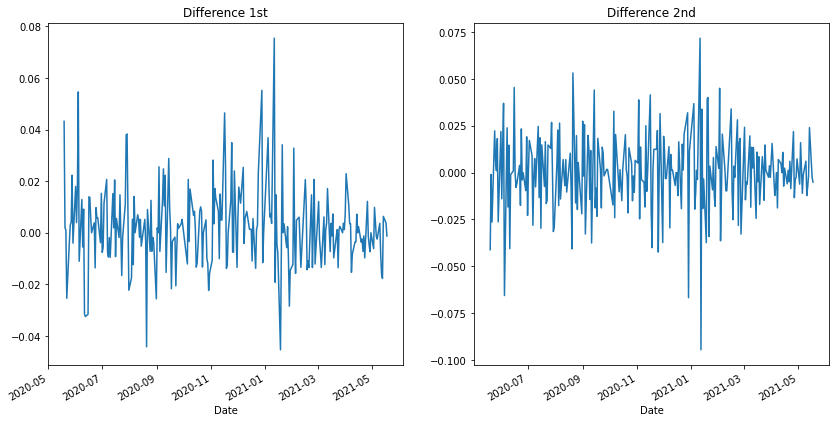

In [57]:
# 차분 안정성 확인 후 d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]


augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]


fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(1,2,1)
diff_1.plot(title='Difference 1st')

ax2 = fig.add_subplot(1,2,2)
diff_2.plot(title='Difference 2nd')

plt.show()

In [58]:
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  # p,d,q 모수
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                    Low   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 605.823
Date:                Fri, 30 Sep 2022   AIC                          -1201.646
Time:                        12:39:57   BIC                          -1184.566
Sample:                             0   HQIC                         -1194.752
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0791      0.139     79.607      0.000      10.806      11.352
ar.L1          1.4526      0.495      2.936      0.003       0.483       2.422
ar.L2         -0.4556      0.493     -0.925      0.3

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


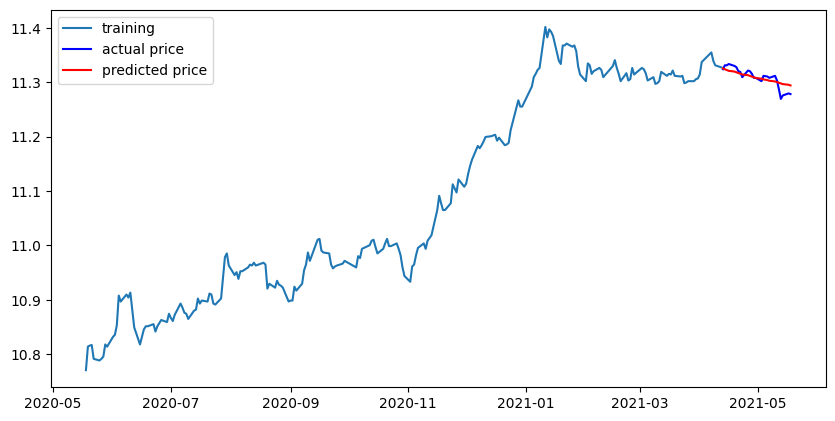

In [59]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [60]:
# 오차함수

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  740729.4155711512
MAE:  696.5705374257103
RMSE:  860.6563864697404
MAPE: 0.86%


Low에서 MAPE : 0.86

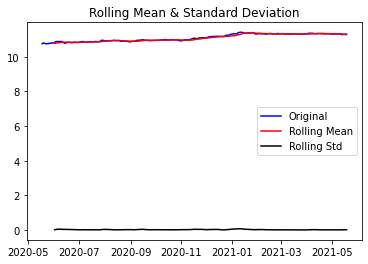

Results of Dickey-Fuller Test:
Test Statistic                  -1.325541
p-value                          0.617408
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


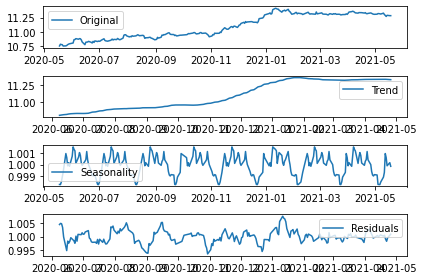

In [61]:
ts = df['Adj Close']
# 결측치 처리
ts = ts.interpolate(method='time')
# 로그 변환
ts_log = np.log(ts)
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [62]:
# residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.217496e+00
p-value                        5.321736e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


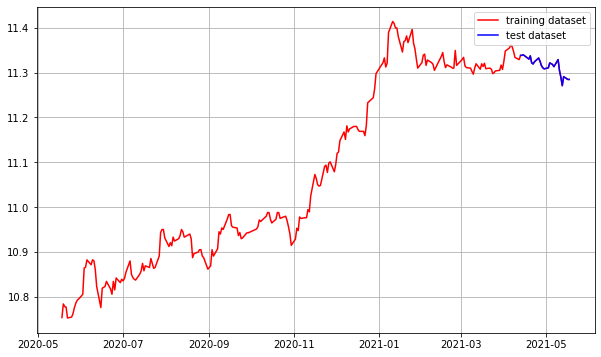

In [63]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 시계열 데이터에선 테스트 데이터셋을 맨 끝에서 가져오는 것이 좋다.

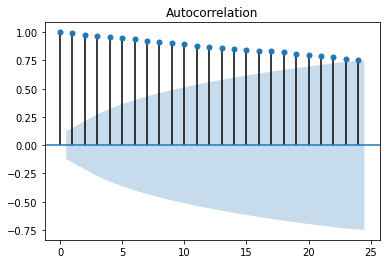

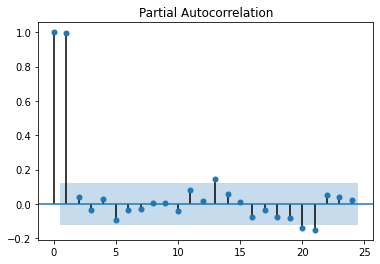

In [64]:
# ACF, PACF 그려보고 p,q 구하기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.529338e+01
p-value                        4.411838e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


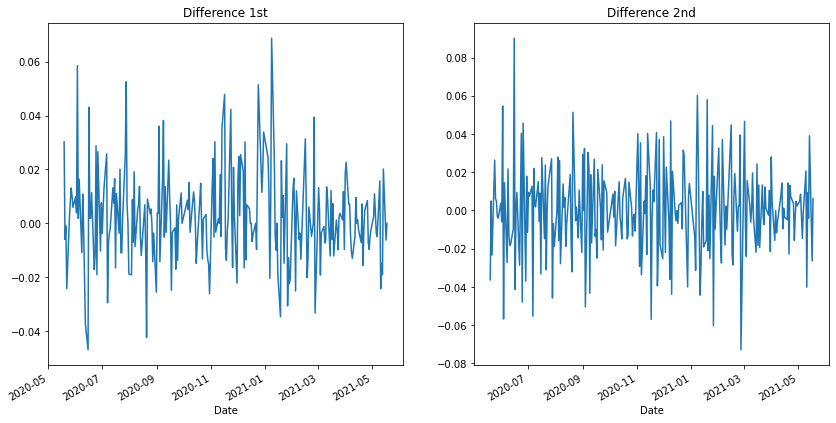

In [65]:
# 차분 안정성 확인 후 d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]


augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]


fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(1,2,1)
diff_1.plot(title='Difference 1st')

ax2 = fig.add_subplot(1,2,2)
diff_2.plot(title='Difference 2nd')

plt.show()

In [66]:
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  # p,d,q 모수
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 582.894
Date:                Fri, 30 Sep 2022   AIC                          -1155.788
Time:                        12:45:06   BIC                          -1138.707
Sample:                             0   HQIC                         -1148.894
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0648      0.140     79.032      0.000      10.790      11.339
ar.L1          1.3207      1.171      1.128      0.259      -0.974       3.616
ar.L2         -0.3244      1.165     -0.278      0.7

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


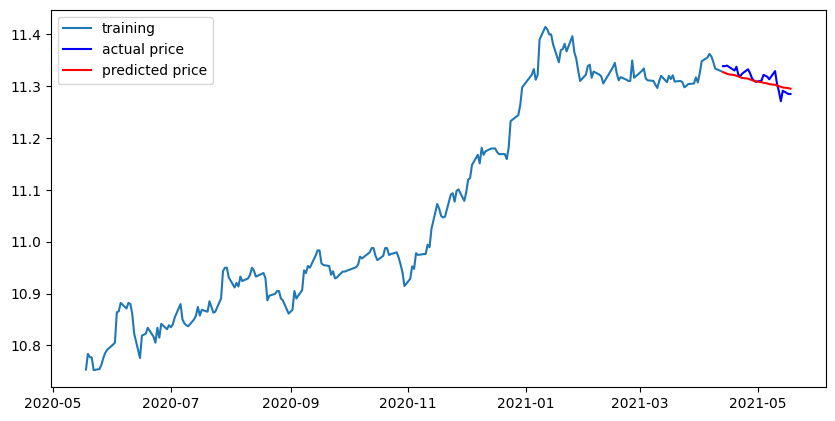

In [67]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [68]:
# 오차함수

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1093952.0417564753
MAE:  873.9791899593926
RMSE:  1045.9216231422292
MAPE: 1.06%


Adj Close에서 MAPE : 1.06

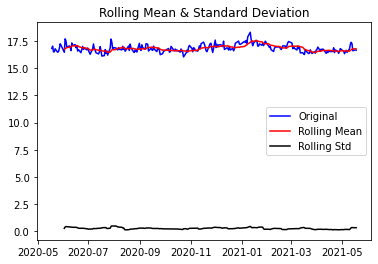

Results of Dickey-Fuller Test:
Test Statistic                  -3.615129
p-value                          0.005478
#Lags Used                       4.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


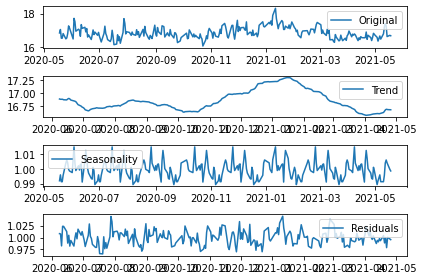

In [69]:
ts = df['Volume']
# 결측치 처리
ts = ts.interpolate(method='time')
# 로그 변환
ts_log = np.log(ts)
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [70]:
# residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.020222e+01
p-value                        5.929287e-18
#Lags Used                     0.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64


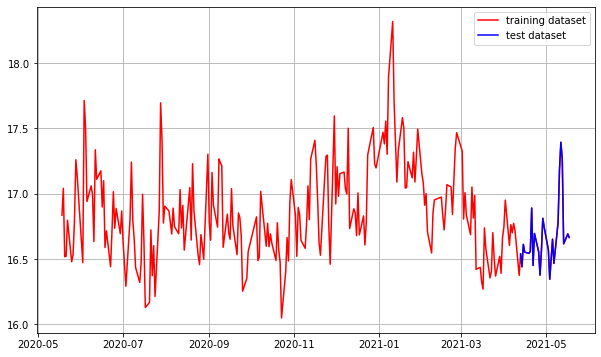

In [71]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 시계열 데이터에선 테스트 데이터셋을 맨 끝에서 가져오는 것이 좋다.

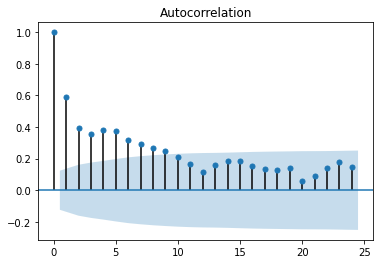

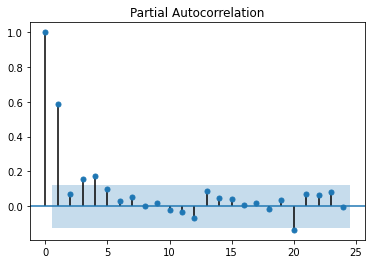

In [72]:
# ACF, PACF 그려보고 p,q 구하기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.232943e+01
p-value                        6.477059e-23
#Lags Used                     3.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


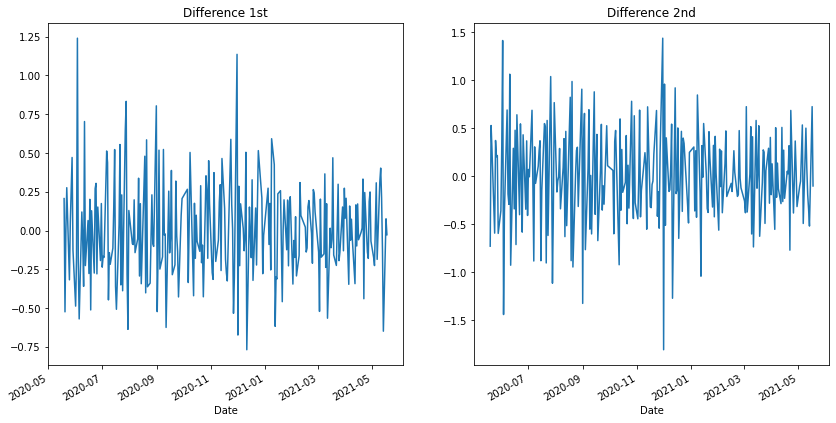

In [73]:
# 차분 안정성 확인 후 d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]


augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]


fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(1,2,1)
diff_1.plot(title='Difference 1st')

ax2 = fig.add_subplot(1,2,2)
diff_2.plot(title='Difference 2nd')

plt.show()

In [104]:
# Build Model
model = ARIMA(train_data, order=(2, 1, 1))  # p,d,q 모수
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  225
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -35.048
Date:                Fri, 30 Sep 2022   AIC                             78.095
Time:                        12:50:53   BIC                             91.742
Sample:                             0   HQIC                            83.604
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2845      0.088      3.239      0.001       0.112       0.457
ar.L2         -0.1319      0.087     -1.517      0.129      -0.302       0.038
ma.L1         -0.7748      0.075    -10.388      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


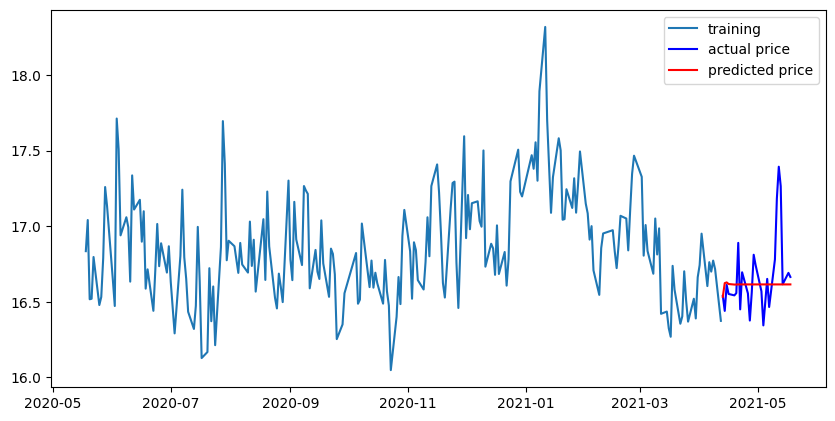

In [105]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [106]:
# 오차함수

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  34798502563315.94
MAE:  3440226.39760199
RMSE:  5899025.560490134
MAPE: 15.55%


여러 order를 시도해본 결과 (2,1,1)에서 MAPE가 15.55% 로 가장 낮았다.

## 결론

각 컬럼에 대한 ARIMA 모델 예측값의 MAPE는 아래와 같다.

Open : 0.88%  
High : 1.67%  
Low : 0.86%  
Close : 1.03%  
Adj Close : 1.06%  
Volume : 15.55% 

# Reference

https://leedakyeong.tistory.com/entry/Python-%EB%82%A0%EC%94%A8-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0Kaggle%EB%A1%9C-ARIMA-%EC%A0%81%EC%9A%A9%ED%95%98%EA%B8%B0

https://byeongkijeong.github.io/ARIMA-with-Python/

https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

# 회고

이번 실습에선 ARIMA를 통해 시계열 데이터를 예측하는 모델을 만들었다. 이전에 했었던 데이터와 모델은 다양한 인풋을 받고 그것들을 토대로 예측모델을 만드는 것이었다면 ARIMA는 시간 단 하나만을 인풋 데이터로서 사용한다. 이전에는 결과에 영향을 주는 많은 요소를 고려해야했는데, 그 덕에 손쉽게 높은 예측률을 보이는 모델을 만들 수 있었다. 그러나 이번에는 단 하나의 데이터 컬럼만을 가지고 다음을 예측해야하므로 시계열 데이터를 안정적으로 만드는 것이 중요했다.

예측모델이란 기본적으로 입력과 출력이 어떠한 상관관계가 있어서 입력 데이터만으로 출력을 예상할 수 있어야만 작용할 수 있다. 따라서 시계열 데이터에선 시간에 따른 흐름이 결과에 유의미하고 예측가능한 영향을 주고 있어야만 적합한 모델을 만들 수 있는 것이다. 그 조건이 바로 '시계열이 안정적일 것'이다. 안정적인 시계열은 평균, 분산, 자기공분산이 일정해야한다. 이것을 알기 위해 귀무가설을 세우고 그것이 틀렸음을 증명하여 기각, 대립가설을 채택하는 방식을 사용한다. '시계열이 안정적이지 않음' 이라는 귀무가설의 p-value가 낮으면 그 주장을 기각하고 '시계열이 안정적임'이라는 대립가설을 채택하는 것이다.

그러나 우리가 안정적이라고 생각하는 데이터들은 그 자체로는 위의 세 가지가 일정하지 않은 경우가 많다. 따라서 그런 시계열 데이터들을 안정적으로 바꿔줘야한다. 이를 위해 로그함수 변환, 추세 상쇄를 통한 이동 평균 제거, 차분을 통한 계절성 제거 등을 사용한다. 파이썬에선 statsmodels 라이브러리 내의 seasonal_decompose 메서드를 통해 이동 평균과 계절성을 쉽게 제거할 수 있다. 이렇게 두 가지를 제거하고 나면 Residual(잔차)가 남는데 이것의 p-value가 바로 귀무가설을 기각하기 위한 값이 된다.

시계열 데이터의 예측 모델은 앞에서 말했듯 시간의 흐름만으로 작동한다는 점에서 다른 모델과 다른 양상을 띈다. 특히 시계열 데이터를 안정적으로 바꾸기 위한 과정들은 복잡하긴 하지만 원리적으로는 단순하고 명쾌하게 느껴졌다. 통계적인 기법을 사용하는 것에만 익숙해진다면 비교적 쉽게 이해할 수 있으리라 생각한다. 